## Imports and Data

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

england_matches = pd.read_json('new_data/matches/matches_England.json')
teams = pd.read_json('new_data/teams.json')
england_events = pd.read_json('new_data/events/events_England.json')
players = pd.read_json('new_data/players.json')

## Team Analysis
### Team class for accessing team attributes (id, matches, players, events etc.) 


In [87]:
class team:
    def __init__(self, name:str):
        self.name = name
        self.team_id = self.get_team_id()
        self.matches = self.get_matches()
        self.players = self.get_players()
        self.all_events = self.get_all_events()
    
    def get_team_id(self):
        return int(teams[teams['name'] == self.name]['wyId'])
        
    def get_matches(self, opposition_team:team=None):
        matches = pd.DataFrame(columns=england_matches.columns)
        specific_matches = pd.DataFrame(columns=england_matches.columns)
        
        for index,row in england_matches.iterrows():
            teams_in_match = [int(team) for team in list(row['teamsData'].keys())]
            if opposition_team is None:
                if self.team_id in teams_in_match:
                    matches = matches.append(row)
            else:
                if self.team_id in teams_in_match and opposition_team.team_id in teams_in_match:
                    specific_matches = specific_matches.append(row)
                
        if opposition_team is None:     
            return matches
        else:
            return specific_matches
    
    def get_players(self):
        return players[players['currentTeamId'] == self.team_id]
    
    def get_players_in_match(self, match_id:int):
        target_match_events = self.all_events[self.all_events['matchId'] == match_id]
        target_match_player_ids = list(set(target_match_events['playerId'].tolist()))
        target_match_players = self.players[self.players['wyId'].isin(target_match_player_ids)]
        return target_match_players
    
    def get_all_events(self):
        return england_events[england_events['teamId'] == self.team_id]


## Graphics Generation

In [199]:
from matplotlib.patches import Arc

kde_plot = None

def draw_pitch(match=None, team=None, player=None, event=None):
    global ax
    
    fig = plt.figure()
    fig.set_size_inches(14,7)

    ax = plt.subplot(111)
    
    ax.set_title('{} \n {} - {} - {}'.format(match, team, player, event), fontsize=20)
    
    #touchline
    plt.plot([0,0], [-5,105], 'k') #left length
    plt.plot([0,100], [105,105], 'k') #upper width
    plt.plot([100,100], [-5,105], 'k') #right length
    plt.plot([100,0], [-5,-5], 'k') #lower width
    plt.plot([50,50], [-5,105], 'k') #halfway line

    #center
    center_circle = plt.Circle((50,50), radius=7, color='black', fill=False)
    center_spot = plt.Circle((50,50), radius=0.7, color='black', fill=True)
    ax.add_artist(center_circle)
    ax.add_artist(center_spot)

    #left 18 yard box
    plt.plot([0,12], [32,32], 'k')
    plt.plot([0,12], [69,69], 'k')
    plt.plot([12,12], [32,69], 'k')
    left_d = Arc((6, 50), width=18.3, height=20, theta1=310, theta2=50, color='black')
    ax.add_patch(left_d)

    #left 6 yard box
    plt.plot([0,4], [41.25,41.25], 'k')
    plt.plot([0,4], [59.75,59.75], 'k')
    plt.plot([4,4], [59.75,41.25], 'k')

    #right 18 yard box
    plt.plot([100,88], [32,32], 'k')
    plt.plot([100,88], [69,69], 'k')
    plt.plot([88,88], [32,69], 'k')
    right_d = Arc((94, 50), width=18.3, height=20, theta1=130, theta2=230, color='black')
    ax.add_patch(right_d)

    #right 6 yard box
    plt.plot([100,96], [41.25,41.25], 'k')
    plt.plot([100,96], [59.75,59.75], 'k')
    plt.plot([96,96], [59.75,41.25], 'k')
    
    return fig, ax

#dataframe should be an 'events' dataframe
def draw_heatmap(dataframe):
    global kde_plot
    kde_plot = sns.kdeplot(dataframe['x_start'], dataframe['y_start'], clip=((0,100), (-5,105)), shade=True, shade_lowest=False, cmap='Greens', n_levels = 20)
    plt.axis('off')

def draw_scatter(dataframe):
    global kde_plot
    sns.scatterplot(dataframe['x_start'], dataframe['y_start'])
    plt.axis('off')

# plt.show()

## Dashboard

In [201]:
from ipywidgets import interact, interactive, interact_manual, widgets, Layout
import warnings 
warnings.filterwarnings('ignore')

def team_view_dashboard():
    #global variables whose values will be updated with every successive selection : filtering achieved through modification of these global vars
    team_1, team_2 = None, None
    matches = None
    target_match = None
    target_team = None
    target_player = None
    events = None
    selected_events = None
    target_events = None

    #First selector that user sees is team selector : get its options
    england_teams = pd.DataFrame(columns=teams.columns)
    for index,row in teams.iterrows():
        if row['area']['name'] == 'England':
            england_teams = england_teams.append(row)
    team_selector_options = sorted(england_teams['name'].tolist())

    #create team selectors - first interactive element to be called, invocation is on last line 
    team_1_selector = widgets.Dropdown(options=team_selector_options, description='Team 1:')
    team_2_selector = widgets.Dropdown(options=team_selector_options, description='Team 2:')

    def select_teams(team_1_selector, team_2_selector):
        global team_1, team_2, matches

        team_1 = team(team_1_selector)
        team_2 = team(team_2_selector)
        matches = team_1.get_matches(team_2)

        #teams selected, call match selector to select one of 2 matches between them
        match_selector = widgets.Dropdown(options=matches['label'].tolist(), description='Match:', layout=Layout(margin='0px 0px 0px -3px'))
        interact(select_match, match_selector=match_selector)

    def select_match(match_selector) -> pd.DataFrame:
        global matches, target_match, team_1, team_2

        target_match = matches[matches['label'] == match_selector]
        display(target_match) #for debugging
    
        #match selected, select which team in match to analyse
        target_team_selector = widgets.Dropdown(options=[team_1.name, team_2.name], description='Target Team:', layout=Layout(margin='0px 0px 0px -8px'))
        interact(select_team, team_selector=target_team_selector)

    def select_team(team_selector):
        global team_1, team_2, target_match, target_team, events

        target_team = team_1 if team_selector == team_1.name else team_2

        events = target_team.all_events[target_team.all_events['matchId'] == int(target_match['wyId'])] 
        
        #unwrap xy coords of events : originally stored as dictionary elements in column 'positions'
        events['x_start'] = events.apply(lambda row: row['positions'][0]['x'], axis=1)
        events['y_start'] = events.apply(lambda row: 100-row['positions'][0]['y'], axis=1)
        
        #event times measured from start of every half => have to check which period an event is in : avoid by measuring all events from start of first half
        events.loc[events.matchPeriod == '2H', 'eventSec'] = 45*60 + events['eventSec']
        
        #target team selected, now select (or not) target player
        players_in_target_match = target_team.get_players_in_match(match_id=int(target_match['wyId']))
        player_options = sorted(players_in_target_match['shortName'].tolist())
        player_options.insert(0, 'All Players')
        
        player_selector = widgets.Dropdown(options=player_options, description='Player:', layout=Layout(margin='0px 0px 0px -14px'))
        interact(select_player, player_selector=player_selector)

    def select_player(player_selector):
        global target_player, target_team, events
        
        target_player_name = player_selector
                                
        #filter events only if a player is selected
        if target_player_name != 'All Players':
            target_player = target_team.players[target_team.players['shortName'] == target_player_name]
        else:
            target_player = None
            
        #target team selected, now select type of event to analyse
        event_selector = widgets.Dropdown(options=sorted(set(events['eventName'].tolist())), description='Event:', layout=Layout(margin='0px 0px 0px -20px'))
        interact(select_event, event_selector=event_selector)

        
    def select_event(event_selector):
        global target_team, target_player, events, selected_events
        
        if target_player is None:
            selected_events = events[events['eventName'] == event_selector]
        else:
            target_player_id = int(target_player['wyId'])
            target_player_events = events[events['playerId'] == target_player_id]
            selected_events = target_player_events[target_player_events['eventName'] == event_selector]
        
        #type of event selected, now select time interval 
        range_selector = widgets.IntRangeSlider(value=[0, 90], min=0, max=90, step=10,description='Interval:',disabled=False, layout=Layout(margin='0px 0px 0px 1px'))
        interact(select_range, range_selector=range_selector)

    def select_range(range_selector):
        global selected_events, target_match, target_team, target_player, target_events

        #target events is selected_events constrained to a particular interval
        target_events = selected_events[selected_events['eventSec'] >= range_selector[0] * 60]
        target_events = target_events[target_events['eventSec'] <= range_selector[1] * 60]
        
#         print(target_events.shape) #for debugging

        #======= EVERYTHING SELECTED, LEZZGO ==========#
        plot_individual_events = widgets.Checkbox(value=False,description=': Plot individual events', indent=True, layout=Layout(margin='0px 0px 0px -20px'))
        interact(plot, plot_individual_events=plot_individual_events)
        
        
    def plot(plot_individual_events):
        global selected_events, target_match, target_team, target_player, target_events
        
        # set plot title : get target player name, else write 'All Players'
        if isinstance(target_player, pd.DataFrame):
            player_name = target_player.iloc[0]['firstName'] + ' ' + target_player.iloc[0]['lastName']
        else:
            player_name = 'All Players'
            
        draw_pitch(target_match.iloc[0]['label'], target_team.name, player_name, target_events.iloc[0]['eventName'])
        #prevent heatmap generation for sparse dataframes
        try:
            draw_heatmap(target_events)
            if plot_individual_events:
                draw_scatter(target_events)
        except Exception as e:
            #print(e) #for debugging
            print("Not Enough Events For Density Estimation")

    #invoke team selector : get the ball rolling
    interact_manual(select_teams, team_1_selector=team_1_selector, team_2_selector=team_2_selector)

In [202]:
team_view_dashboard()

interactive(children=(Dropdown(description='Team 1:', options=('AFC Bournemouth', 'Arsenal', 'Brighton & Hove …

## Build-Up to Goal Map : Still Under Development

[28, 532, 924, 953]

[(66, 70), (59, 86), (75, 86), (72, 63), (85, 56), (87, 52), (89, 61), (92, 50)]


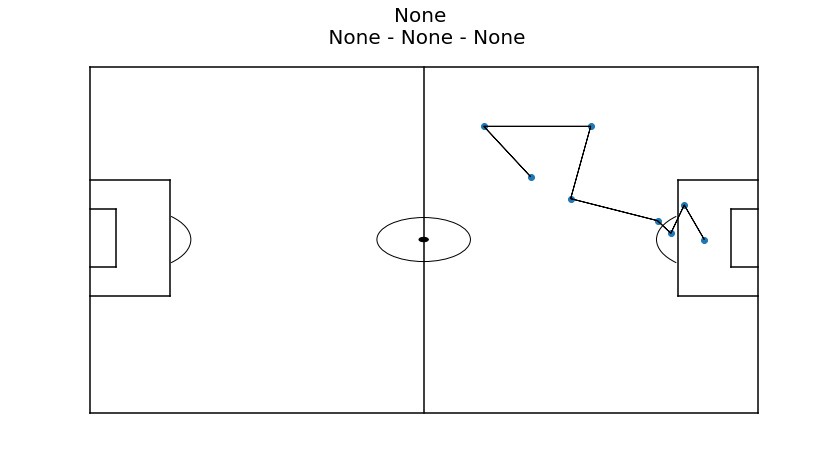

In [220]:
import plotly.express as px

afc = team('Arsenal')
afc_lei_events = afc.all_events[afc.all_events['matchId'] == 2499719].reset_index(drop=True)
afc_lei_shots = afc_lei_events[afc_lei_events['eventName'] == 'Shot']

afc_lei_goals = pd.DataFrame(columns=afc_lei_shots.columns)
afc_lei_goal_indices = []

for index,row in afc_lei_shots.iterrows():
    tags = [pair['id'] for pair in row['tags']]
    if 101 in tags:
        afc_lei_goals = afc_lei_goals.append(row)
        afc_lei_goal_indices.append(index)
        
# display(afc_lei_goals)
display(afc_lei_goal_indices)


def get_events_leading_to_goal(goal_index):
    events_leading_to_goal = afc_lei_events.loc[goal_index-7:goal_index]
    events_leading_to_goal['x_start'] = events_leading_to_goal.apply(lambda row: row['positions'][0]['x'], axis=1)
    events_leading_to_goal['y_start'] = events_leading_to_goal.apply(lambda row: 100-row['positions'][0]['y'], axis=1)
#     display(events_leading_to_goal)

    fig, ax = draw_pitch()
    scatter = ax.scatter(x=events_leading_to_goal['x_start'], y=events_leading_to_goal['y_start'])
    coords = list(zip(events_leading_to_goal['x_start'], events_leading_to_goal['y_start']))
    print(coords)
    arrow_params = {'length_includes_head':True}
    for index,tup in enumerate(coords[:len(coords)-1]):
        plt.arrow(x=tup[0], y=tup[1], dx=coords[index+1][0]-tup[0], dy=coords[index+1][1]-tup[1], **arrow_params)
    
    plt.axis('off')

get_events_leading_to_goal(532)

    
